# Resnet Clustering

This notebook will use a pretrained (on imagenet) resnet 34 model and then perform clustering on the output of the body of this model.

## Data Imports

In [1]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 20kB/s 
     |████████████████████████████████| 4.0MB 34.0MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101


In [0]:
from fastai import *
import torch
from torch import nn
import imageio
from fastai.vision import *
import os
import torch.nn.functional as F
import numpy as np
from automatic_asset_classification import model_layers

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount = False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/automatic-asset-classification


## Import Data

In [4]:
np.random.seed(3333)
torch.manual_seed(3333)
image_path = "/content/drive/My Drive/automatic-asset-classification/data/final_dataset"
size = 224
batchsize = 32

tfms = get_transforms(do_flip = True)
src = (ImageList.from_folder(image_path).split_by_rand_pct().label_from_folder())
data = (src.transform(tfms, size=size, resize_method=ResizeMethod.CROP)
        .databunch(bs=batchsize)
        .normalize(imagenet_stats))
print("imported")

imported


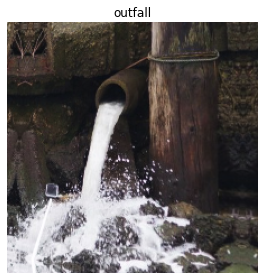

In [5]:
data.show_batch(rows=1)

## Clustering

Due to the other methods requiring training, this method will only use the validation set also for clustering.

In [0]:
class ResnetEncoder(nn.Module):
    def __init__(self):
        super(ResnetEncoder, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', 
                                pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[:-2]))
        for param in resnet.parameters():
            param.requires_grad = False

        self.feature_extract = resnet

        self.ConcatPool2D = model_layers.AdaptiveConcatPool2d()

    def forward(self,x):
        x = self.feature_extract(x)
        x = self.ConcatPool2D(x)
        return x.squeeze()

In [7]:
encoder = ResnetEncoder()
learn = Learner(data, encoder, metrics=error_rate, loss_func = F.mse_loss)

Downloading: "https://github.com/pytorch/vision/archive/v0.5.0.zip" to /root/.cache/torch/hub/v0.5.0.zip
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [8]:
preds, acts = learn.get_preds()

In [9]:
len(preds)

110

In [0]:
cluster_data = preds.numpy()

In [0]:
cluster_data_st = (cluster_data - cluster_data.mean())/cluster_data.std()

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
cluster_data_pca = pca.fit_transform(cluster_data_st)

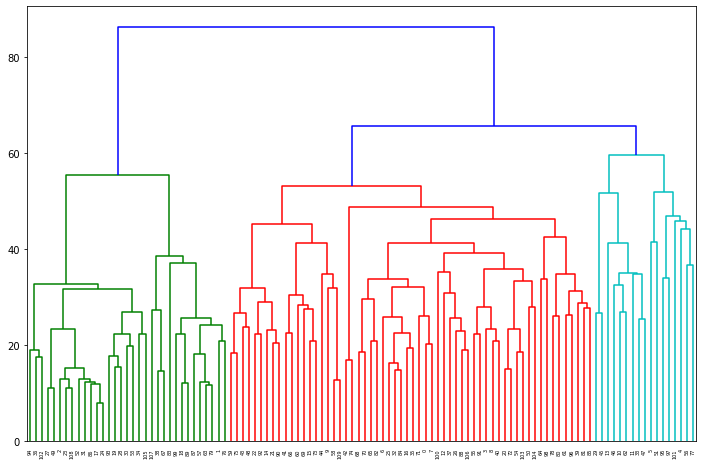

In [28]:
linked = linkage(cluster_data_pca, method = 'ward')
fig = plt.figure(figsize = (12,8))
dendrogram(linked,
            orientation='top',
            #labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [0]:
X_embedded = TSNE(n_components=2, perplexity = 5).fit_transform(cluster_data_pca)
X_embedded2 = TSNE(n_components=2, perplexity = 30).fit_transform(cluster_data_pca)
X_embedded3 = TSNE(n_components=2, perplexity = 50).fit_transform(cluster_data_pca)

In [0]:
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
clusters=cluster.fit_predict(cluster_data_pca)

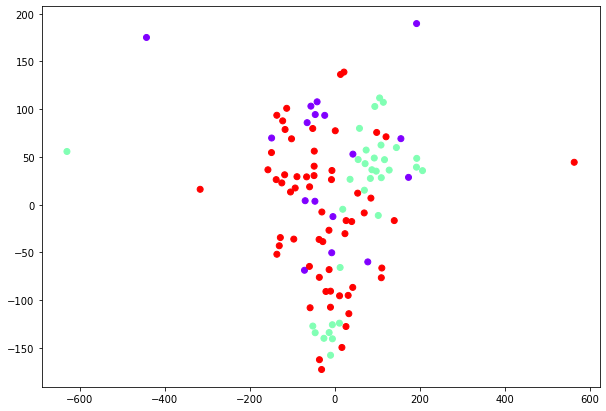

In [32]:
plt.figure(figsize=(10, 7))
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=cluster.labels_, cmap='rainbow')

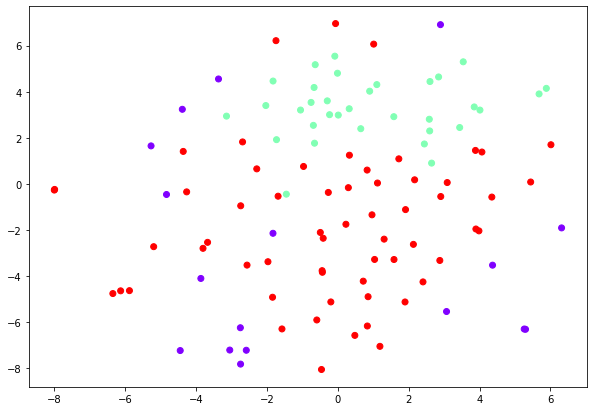

In [33]:
plt.figure(figsize=(10, 7))
plt.scatter(X_embedded2[:,0], X_embedded2[:,1], c=cluster.labels_, cmap='rainbow')

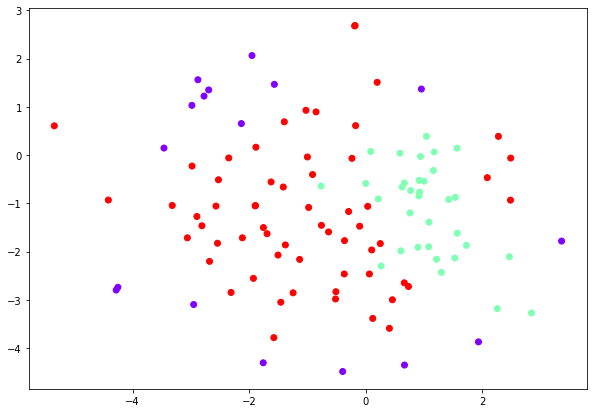

In [34]:
plt.figure(figsize=(10, 7))
plt.scatter(X_embedded3[:,0], X_embedded3[:,1], c=cluster.labels_, cmap='rainbow')

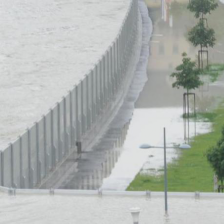

In [42]:
data.valid_ds[0][0]

In [0]:
ones=[]
twos=[]
threes=[]
for i in range(len(clusters)):
    if clusters[i] == 0:
        ones.append(int(acts[i]))
    if clusters[i] == 1:
        twos.append(int(acts[i]))
    if clusters[i] == 2:
        threes.append(int(acts[i]))

In [49]:
set(ones), set(twos), set(threes)

({0, 2, 3, 4}, {0, 3, 4}, {0, 1, 2, 3, 4, 5})

In [51]:
data.classes

['embankment', 'flood_gate', 'flood_wall', 'outfall', 'reservoir', 'weir']

In [0]:
one_idx = []
two_idx = []
three_idx = []

for i in range(len(clusters)):
    if clusters[i] == 0:
        one_idx.append(i)
    if clusters[i] == 1:
        two_idx.append(i)
    if clusters[i] == 2:
        three_idx.append(i)

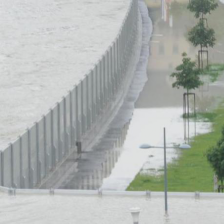

In [55]:
data.valid_ds[three_idx[0]][0]

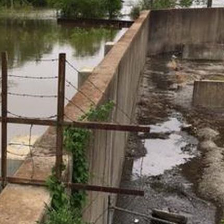

In [56]:
data.valid_ds[three_idx[10]][0]

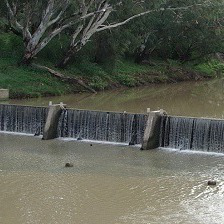

In [57]:
data.valid_ds[three_idx[20]][0]

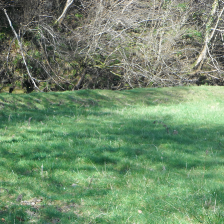

In [58]:
data.valid_ds[two_idx[0]][0]

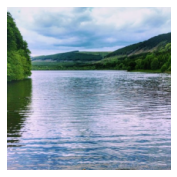

In [66]:
data.valid_ds[two_idx[10]][0].show()

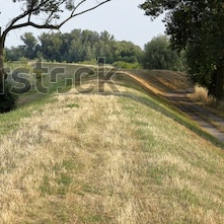

In [60]:
data.valid_ds[two_idx[20]][0]

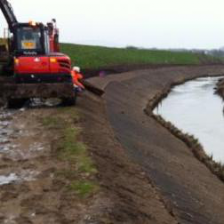

In [61]:
data.valid_ds[one_idx[0]][0]

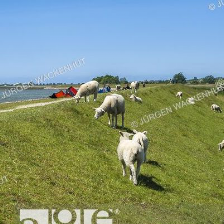

In [62]:
data.valid_ds[one_idx[10]][0]

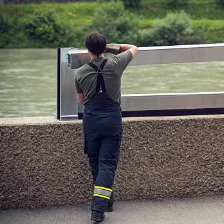

In [64]:
data.valid_ds[one_idx[15]][0]

In [0]:
for idx in three_idx:
    data.valid_ds[idx][0].save("/content/drive/My Drive/automatic-asset-classification/outputs/resnet_encoder"
                               "/class3/"+str(idx)+".png")

In [0]:
for idx in two_idx:
    data.valid_ds[idx][0].save("/content/drive/My Drive/automatic-asset-classification/outputs/resnet_encoder"
                               "/class2/"+str(idx)+".png")

In [0]:
for idx in one_idx:
    data.valid_ds[idx][0].save("/content/drive/My Drive/automatic-asset-classification/outputs/resnet_encoder"
                               "/class1/"+str(idx)+".png")